In [14]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator, DayLocator
import matplotlib as mpl
import peakutils
import warnings
import pytz
warnings.filterwarnings("ignore")

register_matplotlib_converters()

# File locations
#----------------
# the_gases = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/'
pngs = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/pngs/'
# the_folder = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/'
# aurn_ratified = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/q12021/'
data_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/jun_to_sept_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'

In [3]:
# Load the dfs
# --------------
# oxaria_gases = pd.read_feather(
#     the_folder+'q12021/oxaria_gases_536_stable15_full_corr_rat+2021.ftr').set_index(['tag', 'rec'])
oxaria_pm = pd.read_feather(
    data_home+'oxaria_pm_stable15_full_corr_oct_2021.ftr').set_index(['tag', 'rec'])
auto_merged = pd.read_feather(
    data_home+'auto_merged_ratified+2021_oct_update.ftr').set_index(['rec'])
lockdown_dates = pd.read_feather(
    stats_home+'lockdown_dates.ftr')

In [5]:
id1 = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
lockdown_dates['id1'] = id1
#lockdown_dates.drop('id',axis=1, inplace=True)
lockdown_dates.rename(columns={'id1':'code'},inplace=True)
lockdown_dates

,id,startdate,enddate,status,code
0,1970-01-01 00:00:00+00:00,2020-01-01 00:00:00+00:00,2020-03-11 00:00:00+00:00,Normal times,a
1,1970-01-01 00:00:00.000000001+00:00,2020-03-12 00:00:00+00:00,2020-03-23 00:00:00+00:00,Entering LD,b
2,1970-01-01 00:00:00.000000002+00:00,2020-03-24 00:00:00+00:00,2020-05-12 00:00:00+00:00,National LD,c
3,1970-01-01 00:00:00.000000003+00:00,2020-05-13 00:00:00+00:00,2020-06-18 00:00:00+00:00,1st easing,d
4,1970-01-01 00:00:00.000000004+00:00,2020-06-19 00:00:00+00:00,2020-07-12 00:00:00+00:00,2nd easing,e
5,1970-01-01 00:00:00.000000005+00:00,2020-07-13 00:00:00+00:00,2020-09-23 00:00:00+00:00,3rd easing,f
6,1970-01-01 00:00:00.000000006+00:00,2020-09-24 00:00:00+00:00,2020-10-30 00:00:00+00:00,1st tightening,g
7,1970-01-01 00:00:00.000000007+00:00,2020-10-31 00:00:00+00:00,2020-11-04 00:00:00+00:00,Tier 2,h
8,1970-01-01 00:00:00.000000008+00:00,2020-11-05 00:00:00+00:00,2020-12-01 00:00:00+00:00,National LD2,i
9,1970-01-01 00:00:00.000000009+00:00,2020-12-02 00:00:00+00:00,2020-12-25 00:00:00+00:00,Tier 2.2,j


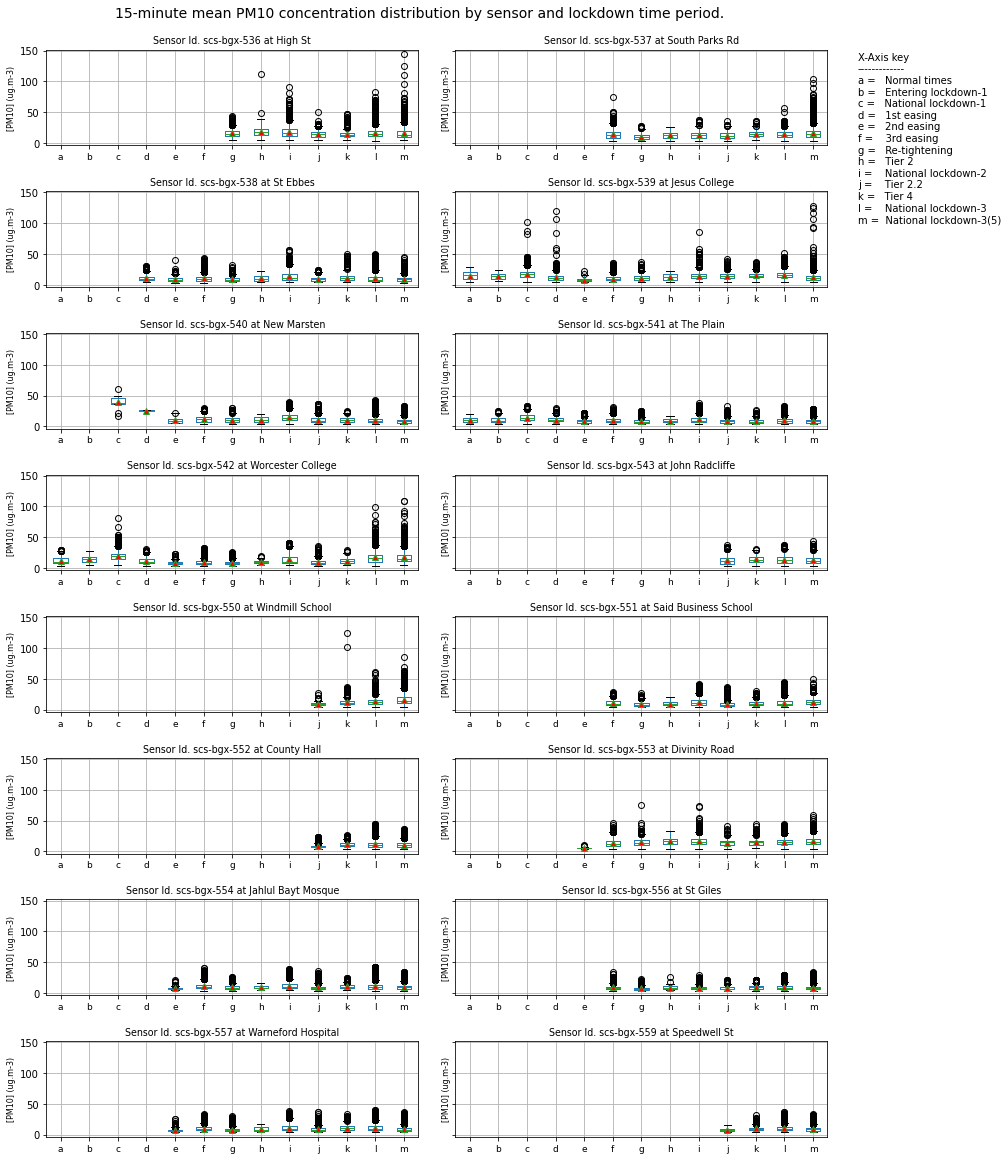

In [52]:
# Calc box plots of observation distribution by sensor & lockdown period - pm10
# ------------------------------------------------------------------------------

# calc simple descriptive simple stats for the dates by sensor as a list of dfs
values = [] 
for idx0, row0 in oxaria_pm.query('tag != "scs-bgx-558"').groupby('tag'):
    for idx1, row1 in lockdown_dates.iterrows():
        name = row0['name'].unique()[0]
        tmpdf0 = pd.DataFrame(
            data={
                'tag': [idx0],
                'id': [row1[4]],
                'rec': [row1[1]],
                'val.pm10_1_c2_SH_xt': [np.nan],
                'name': [name]
            })
        tmpdf1 = row0.reset_index().query('@row1[1] <= rec <= @row1[2]')
        tmpdf1['id'] = row1[4]
        tmpdf1['status'] = row1[3]
        tmpdf1 = tmpdf1[[
            'tag', 'id', 'rec', 'val.pm10_1_c2_SH_xt', 'status', 'name'
        ]]
        tmpdf2 = pd.concat([tmpdf0, tmpdf1]).sort_values(by=['tag', 'rec'],
                                                         axis=0)
        values.append(tmpdf2)
df = pd.concat(values).set_index('tag')
df.reset_index(inplace=True)
df.reset_index(inplace=True)

fig, axes = plt.subplots(nrows=8,
                         ncols=2,
                         sharex=False, sharey=True, 
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    '15-minute mean PM10 concentration distribution by sensor and lockdown time period.  \n',
    fontsize=14,
    y=0.91)

for i, s in df.groupby('tag'):
    ax = axes_list.pop(0)
    t_name = s['name'].unique()
    s.pivot(index="index", columns="id",
            values="val.pm10_1_c2_SH_xt").boxplot(ax=ax,
                                            boxprops={'color': 'tab:blue'},
                                            meanprops={"markerfacecolor": "r"},
                                            showmeans=True)
    ax.set_title(''.join(str(s['tag'].unique()[0]) + ' - ' + str(s['name'].unique()[0])), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=9)
    ax.set_ylabel('[PM10] (ug.m-3)', fontsize=8)
    ax.set_title(''.join('Sensor Id. '+i+' at '+t_name), fontsize=9.5)

    #ax.set_xlabel('Lockdown period code', fontsize=8)
    ax.grid(True)
    plt.subplots_adjust(wspace=0.1, hspace=0.48)


plt.figtext(
    0.93, 0.76,
    'X-Axis key\n-------------\na =   Normal times\nb =   Entering lockdown-1\nc =   National lockdown-1\nd =   1st easing\ne =   2nd easing\nf =    3rd easing\ng =   Re-tightening\nh =   Tier 2\ni =    National lockdown-2\nj =    Tier 2.2\nk =   Tier 4\nl =    National lockdown-3\nm =  National lockdown-3(5)'
)

#fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'boxplots_pm10_15m_by_sensor_lockdown_period_oct.png', bbox_inches='tight')
plt.show()

for ax in axes_list:
    ax.remove()

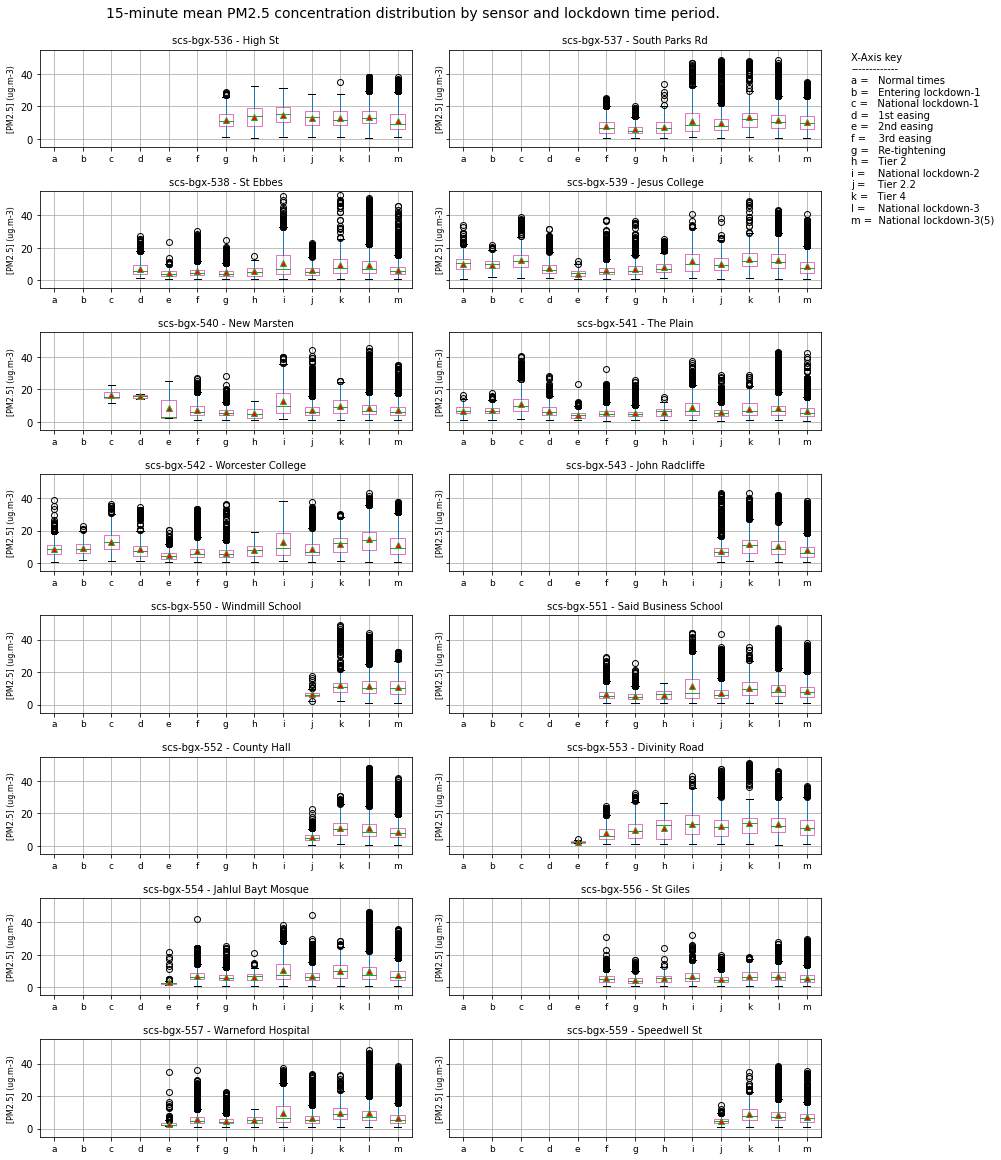

In [51]:
##### Calc box plots of observation distribution by sensor & lockdown period - no2
# ------------------------------------------------------------------------------

# calc simple descriptive simple stats for the dates by sensor as a list of dfs
values = []
for idx0, row0 in oxaria_pm.query('tag != "scs-bgx-558"').groupby('tag'):
    for idx1, row1 in lockdown_dates.iterrows():
        name = row0['name'].unique()[0]
        tmpdf0 = pd.DataFrame(
            data={
                'tag': [idx0],
                'id': [row1[4]],
                'rec': [row1[1]],
                'val.pm2p5_1_c2_S_xt': [np.nan],
                'name': [name]
            })
        tmpdf1 = row0.reset_index().query('@row1[1] <= rec <= @row1[2]')
        tmpdf1['id'] = row1[4]
        tmpdf1['status'] = row1[3]
        tmpdf1 = tmpdf1[['tag', 'id', 'rec', 'val.pm2p5_1_c2_S_xt',
                         'status']]  # .dropna()
        tmpdf2 = pd.concat([tmpdf0, tmpdf1]).sort_values(by=['tag', 'rec'],
                                                         axis=0)
        values.append(tmpdf2)
df = pd.concat(values).set_index('tag')
df.reset_index(inplace=True)
df.reset_index(inplace=True)

fig, axes = plt.subplots(nrows=8,
                         ncols=2,
                         sharex=False,
                         sharey=True,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    '15-minute mean PM2.5 concentration distribution by sensor and lockdown time period.  \n',
    fontsize=14,
    y=0.91)

for i, s in df.groupby('tag'):
    ax = axes_list.pop(0)
    t_name = s['name'].unique()
    s.pivot(index="index", columns="id", values="val.pm2p5_1_c2_S_xt").boxplot(
        ax=ax,
        boxprops={'color': 'tab:pink'},
        meanprops={'markerfacecolor': 'r','color':'r'},
        showmeans=True)
    ax.set_title(''.join(str(s['tag'].unique()[0]) + ' - ' + str(s['name'].unique()[0])), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=9)
    ax.set_ylabel('[PM2.5] (ug.m-3)', fontsize=8)
    #ax.set_xlabel('Lockdown period code', fontsize=8)
    ax.set_ylim(-5, 55)  
    ax.grid(True) 
    plt.subplots_adjust(wspace=0.1, hspace=0.45)

plt.figtext(
    0.93, 0.76,
    'X-Axis key\n-------------\na =   Normal times\nb =   Entering lockdown-1\nc =   National lockdown-1\nd =   1st easing\ne =   2nd easing\nf =    3rd easing\ng =   Re-tightening\nh =   Tier 2\ni =    National lockdown-2\nj =    Tier 2.2\nk =   Tier 4\nl =    National lockdown-3\nm =  National lockdown-3(5)'
)


#fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'boxplots_pm25_15m_by_sensor_lockdown_period_oct.png', bbox_inches='tight')
plt.show()

for ax in axes_list:
    ax.remove()